- Load both CSV files (fake.csv and true.csv) and examine their structure, dimensions, and basic statistics.

- Check for missing values, duplicate entries, inconsistent formatting in dates, and examine the length distribution of titles and text content.

- Add a 'label' column to each dataset (1 for fake news, 0 for true news), then combine both datasets into a single dataframe.

- Examine the distribution of fake vs true news in your merged dataset and decide if balancing is needed.

-  Clean the text data by removing special characters, converting to lowercase, removing stopwords, and applying stemming or lemmatization to both title and text columns.

-  Create additional features such as text length, title length, word count, punctuation density, capital letter ratio, and extract numerical features from the date column.

-  Convert the processed text into numerical features using techniques like TF-IDF (Term Frequency-Inverse Document Frequency) vectorization for both title and text content.

-   Use techniques like SelectKBest, correlation analysis, or feature importance from preliminary models to select the most relevant features.

-   Split your data into training (70-80%), validation (10-15%), and test sets (10-15%) using stratified sampling to maintain label distribution.

-   Train a Random Forest classifier with initial hyperparameters, starting with default values and basic configurations.

-   Use techniques like Grid Search or Random Search with cross-validation to optimize parameters such as number of trees, maximum depth, minimum samples per leaf, and feature selection criteria.

-   Evaluate the model using multiple metrics including accuracy, precision, recall, F1-score, and confusion matrix on both validation and test sets.

-   Analyze which features (words, engineered features) contribute most to the classification decisions.

-   Perform k-fold cross-validation to ensure your model's performance is consistent across different data splits.

-   Save your trained model using serialization techniques for future predictions.

In [23]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import warnings
warnings.filterwarnings('ignore')

# Download NLTK data (run once)
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

The libraries imported here are essential components for building a Natural Language Processing (NLP) pipeline in Python. The nltk library, short for Natural Language Toolkit, is a foundational library widely used for working with human language data. It provides tools for handling various NLP tasks such as tokenization, stemming, lemmatization, part-of-speech tagging, and more.

One of the core tasks in preparing text for analysis is identifying and removing "stopwords" — these are common words like “the,” “is,” “in,” and “and,” which appear frequently in language but typically carry very little unique information. The line from nltk.corpus import stopwords imports a predefined list of such words from the English language, allowing us to filter them out of our dataset and reduce noise. This improves the efficiency and effectiveness of downstream models, as it helps focus on the more meaningful and distinctive words in a document.

Tokenization, achieved here via from nltk.tokenize import word_tokenize, refers to the process of breaking up a string of text into individual words or tokens. This step is essential because most text-based models can’t operate on raw strings; they require structured input, such as a list of words or phrases. Tokenizing also lays the groundwork for applying other transformations, like removing stopwords or calculating word frequencies.

Finally, the TfidfVectorizer class from sklearn.feature_extraction.text transforms the cleaned and tokenized text into a numerical representation using the TF-IDF approach, which stands for Term Frequency–Inverse Document Frequency. This method evaluates the importance of a word in a document relative to a collection of documents (the corpus). By assigning higher weights to words that are unique to a document and downweighting those that appear in many documents, TF-IDF helps emphasize the most informative words. This vectorized representation is what enables machine learning algorithms to effectively process and learn from textual data.

#### Data Loading and Initial Exploration

In [2]:
# Load the datasets
fake_df = pd.read_csv('fake.csv')
true_df = pd.read_csv('true.csv')

# Display basic information about both datasets
print("=== FAKE NEWS DATASET ===")
print(f"Shape: {fake_df.shape}")
print(f"Columns: {fake_df.columns.tolist()}")
print("\nFirst few rows:")
print(fake_df.head())

print("\n=== TRUE NEWS DATASET ===")
print(f"Shape: {true_df.shape}")
print(f"Columns: {true_df.columns.tolist()}")
print("\nFirst few rows:")
print(true_df.head())

# Check for missing values
print("\n=== MISSING VALUES ===")
print("Fake news missing values:")
print(fake_df.isnull().sum())
print("\nTrue news missing values:")
print(true_df.isnull().sum())

=== FAKE NEWS DATASET ===
Shape: (23481, 4)
Columns: ['title', 'text', 'subject', 'date']

First few rows:
                                               title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date  
0  December 31, 2017  
1  December 31, 2017  
2  December 30, 2017  
3  December 29, 2017  
4  December 25, 2017  

=== TRUE NEWS DATASET ===
Shape:

#### Data Labeling and Merging

In [3]:
# Add labels to the datasets
fake_df['label'] = 1  # 1 for fake news
true_df['label'] = 0  # 0 for true news

# Merge the datasets
news_df = pd.concat([fake_df, true_df], ignore_index=True)

print(f"Combined dataset shape: {news_df.shape}")
print(f"\nLabel distribution:")
print(news_df['label'].value_counts())

# Save the merged dataset
news_df.to_csv('news.csv', index=False)
print("\nMerged dataset saved as 'news.csv'")

# Display sample from merged dataset
print("\nSample from merged dataset:")
print(news_df.head())

Combined dataset shape: (44898, 5)

Label distribution:
label
1    23481
0    21417
Name: count, dtype: int64

Merged dataset saved as 'news.csv'

Sample from merged dataset:
                                               title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date  label  
0  December 31, 2017      1  
1  December 31, 2017      1  
2  December 3

#### Exploratory Data Analysis

=== DATASET STATISTICS ===
Total articles: 44898
Fake articles: 23481
True articles: 21417


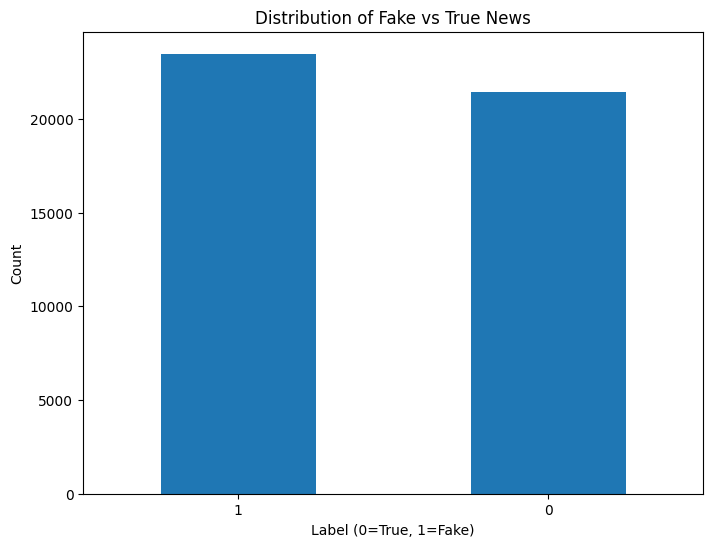

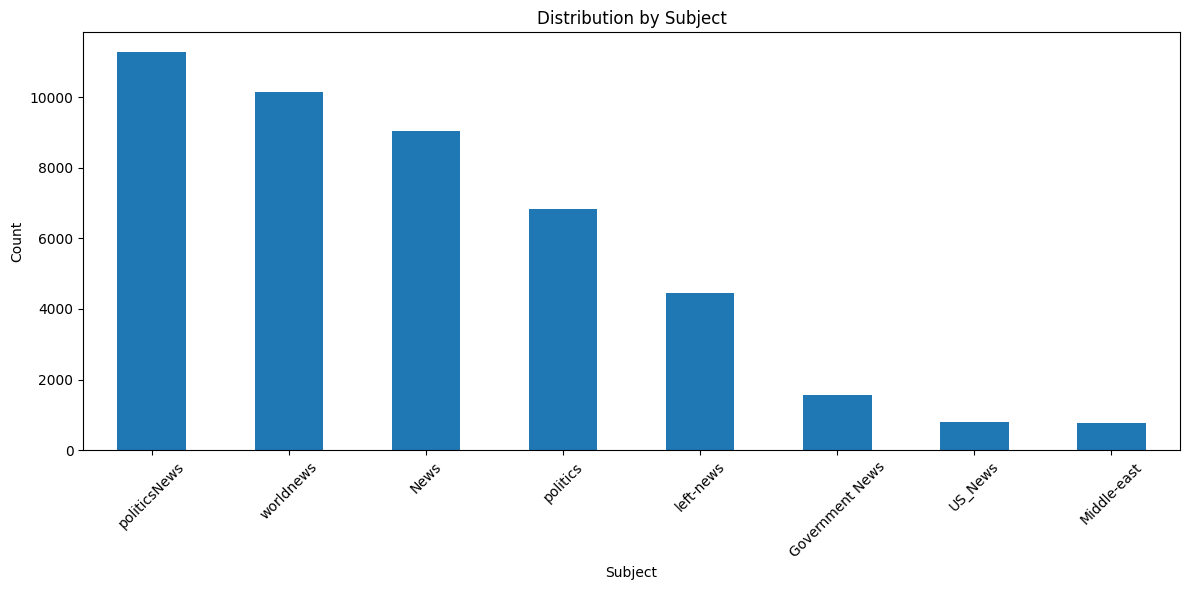

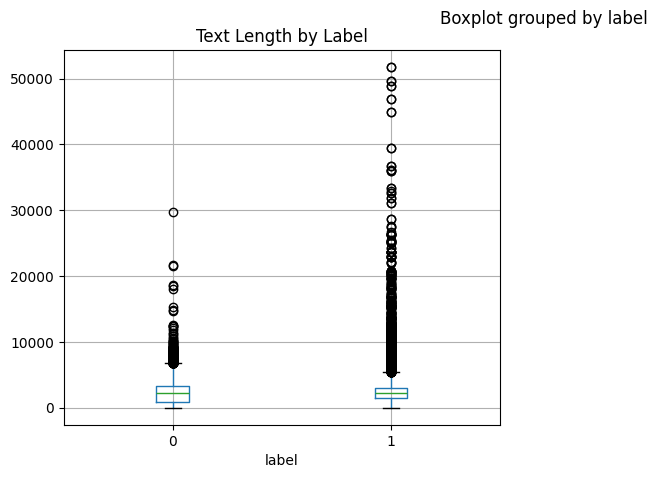

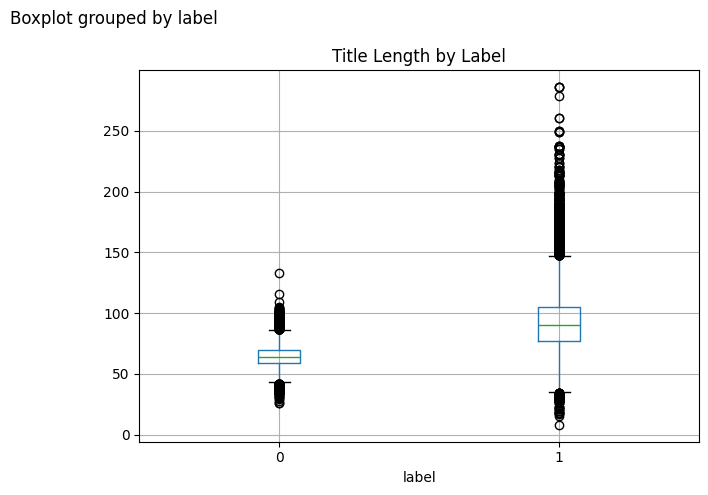

In [6]:
# Basic statistics
print("=== DATASET STATISTICS ===")
print(f"Total articles: {len(news_df)}")
print(f"Fake articles: {len(news_df[news_df['label'] == 1])}")
print(f"True articles: {len(news_df[news_df['label'] == 0])}")

# Visualize label distribution
plt.figure(figsize=(8, 6))
news_df['label'].value_counts().plot(kind='bar')
plt.title('Distribution of Fake vs True News')
plt.xlabel('Label (0=True, 1=Fake)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

# Subject distribution
plt.figure(figsize=(12, 6))
subject_counts = news_df['subject'].value_counts()
subject_counts.plot(kind='bar')
plt.title('Distribution by Subject')
plt.xlabel('Subject')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Text length analysis
news_df['text_length'] = news_df['text'].str.len()
news_df['title_length'] = news_df['title'].str.len()

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
news_df.boxplot(column='text_length', by='label', ax=plt.gca())
plt.title('Text Length by Label')

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 2)
news_df.boxplot(column='title_length', by='label', ax=plt.gca())
plt.title('Title Length by Label')
plt.tight_layout()
plt.show()

#### Data Cleaning and Preprocessing

In [9]:
# Text preprocessing function
def preprocess_text(text):
    if pd.isna(text):
        return ""
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Remove extra whitespace
    text = ' '.join(text.split())
    
    return text

# Apply preprocessing
print("Preprocessing text data...")
news_df['clean_title'] = news_df['title'].apply(preprocess_text)
news_df['clean_text'] = news_df['text'].apply(preprocess_text)

# Combine title and text for better feature extraction
news_df['combined_text'] = news_df['clean_title'] + ' ' + news_df['clean_text']

# Remove rows with empty combined text
news_df = news_df[news_df['combined_text'].str.strip() != '']

print(f"Dataset shape after cleaning: {news_df.shape}")

# Remove stop words function
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word not in stop_words]
    return ' '.join(filtered_text)

# Apply stop words removal (optional - can be computationally intensive)
print("Removing stop words...")
news_df['final_text'] = news_df['combined_text'].apply(remove_stopwords)

Preprocessing text data...
Dataset shape after cleaning: (44898, 10)
Removing stop words...


#### Feature Engineering with TF-IDF

In [10]:
# Initialize TF-IDF Vectorizer
print("Creating TF-IDF features...")
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,  # Limit to top 5000 features
    min_df=2,          # Ignore terms that appear in less than 2 documents
    max_df=0.8,        # Ignore terms that appear in more than 80% of documents
    stop_words='english',
    ngram_range=(1, 2)  # Use both unigrams and bigrams
)

# Fit and transform the text data
X = tfidf_vectorizer.fit_transform(news_df['final_text'])
y = news_df['label']

print(f"Feature matrix shape: {X.shape}")
print(f"Target variable shape: {y.shape}")

# Show most important features
feature_names = tfidf_vectorizer.get_feature_names_out()
print(f"\nSample features: {feature_names[:20]}")

Creating TF-IDF features...
Feature matrix shape: (44898, 5000)
Target variable shape: (44898,)

Sample features: ['abandon' 'abandoned' 'abbas' 'abc' 'abc news' 'abdullah' 'abe' 'abedin'
 'ability' 'able' 'abortion' 'abortions' 'abroad' 'absolute' 'absolutely'
 'abu' 'abuse' 'abuses' 'academic' 'accept']


#### Train-Test Split

In [11]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,      # 20% for testing
    random_state=42,    # For reproducibility
    stratify=y          # Maintain label distribution in both sets
)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")
print(f"\nTraining set label distribution:")
print(pd.Series(y_train).value_counts())
print(f"\nTesting set label distribution:")
print(pd.Series(y_test).value_counts())

Training set shape: (35918, 5000)
Testing set shape: (8980, 5000)

Training set label distribution:
label
1    18785
0    17133
Name: count, dtype: int64

Testing set label distribution:
label
1    4696
0    4284
Name: count, dtype: int64


#### Random Forest Model Training

In [12]:
# Initialize Random Forest Classifier
rf_classifier = RandomForestClassifier(
    n_estimators=100,    # Number of trees
    random_state=42,     # For reproducibility
    max_depth=20,        # Prevent overfitting
    min_samples_split=5, # Minimum samples to split a node
    min_samples_leaf=2,  # Minimum samples in leaf node
    n_jobs=-1           # Use all available processors
)

# Train the model
print("Training Random Forest model...")
rf_classifier.fit(X_train, y_train)
print("Model training completed!")

# Make predictions
y_pred = rf_classifier.predict(X_test)
y_pred_proba = rf_classifier.predict_proba(X_test)

print("Predictions completed!")

Training Random Forest model...
Model training completed!
Predictions completed!


#### Model Evaluation

=== MODEL PERFORMANCE METRICS ===
Accuracy: 0.9951
Precision: 0.9966
Recall: 0.9940
F1-Score: 0.9953

=== DETAILED CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

   True News       0.99      1.00      0.99      4284
   Fake News       1.00      0.99      1.00      4696

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



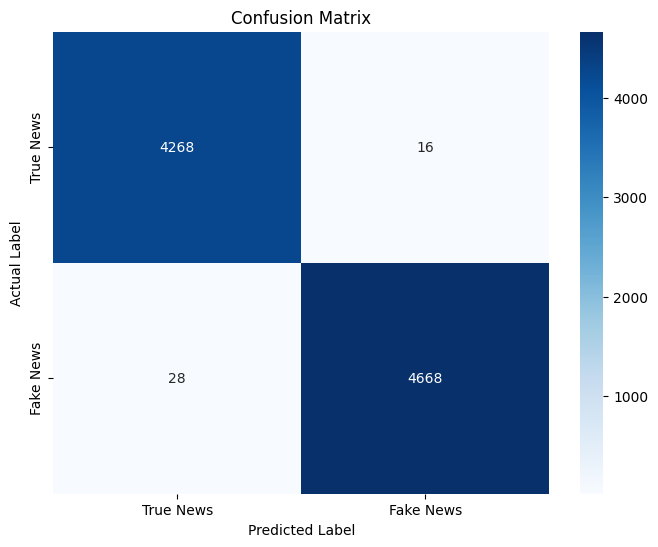

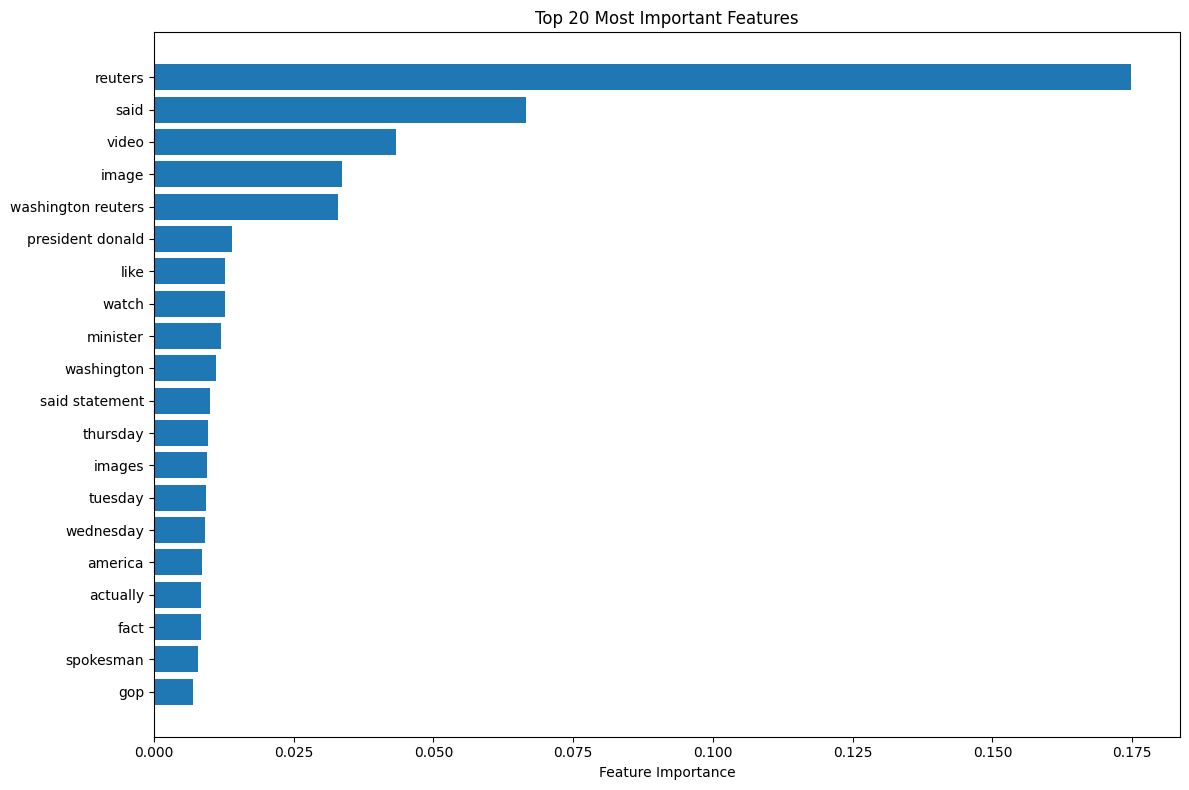

In [13]:
# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("=== MODEL PERFORMANCE METRICS ===")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Detailed classification report
print("\n=== DETAILED CLASSIFICATION REPORT ===")
print(classification_report(y_test, y_pred, target_names=['True News', 'Fake News']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['True News', 'Fake News'],
            yticklabels=['True News', 'Fake News'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# Feature Importance Analysis
feature_importance = rf_classifier.feature_importances_
feature_names = tfidf_vectorizer.get_feature_names_out()

# Get top 20 most important features
top_indices = np.argsort(feature_importance)[::-1][:20]
top_features = [feature_names[i] for i in top_indices]
top_importance = [feature_importance[i] for i in top_indices]

plt.figure(figsize=(12, 8))
plt.barh(range(len(top_features)), top_importance)
plt.yticks(range(len(top_features)), top_features)
plt.xlabel('Feature Importance')
plt.title('Top 20 Most Important Features')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

####  Model Testing with New Examples

In [14]:
# Function to predict new articles
def predict_news(title, text):
    # Combine and preprocess the text
    combined = preprocess_text(title) + ' ' + preprocess_text(text)
    cleaned = remove_stopwords(combined)
    
    # Transform using our fitted vectorizer
    text_vector = tfidf_vectorizer.transform([cleaned])
    
    # Make prediction
    prediction = rf_classifier.predict(text_vector)[0]
    probability = rf_classifier.predict_proba(text_vector)[0]
    
    result = "FAKE" if prediction == 1 else "TRUE"
    confidence = max(probability) * 100
    
    return result, confidence

# Test with sample articles
test_articles = [
    {
        "title": "Scientists Discover New Planet in Solar System",
        "text": "Researchers at NASA have announced the discovery of a new planet in our solar system, located beyond Pluto. The planet, tentatively named Planet X, is approximately twice the size of Earth."
    },
    {
        "title": "Breaking: Alien Spaceship Lands in New York City",
        "text": "A massive alien spacecraft has reportedly landed in Times Square, New York City. Witnesses claim to have seen strange beings emerging from the craft. Government officials have not yet commented on the situation."
    }
]

print("=== TESTING WITH SAMPLE ARTICLES ===")
for i, article in enumerate(test_articles, 1):
    result, confidence = predict_news(article["title"], article["text"])
    print(f"\nArticle {i}:")
    print(f"Title: {article['title']}")
    print(f"Prediction: {result}")
    print(f"Confidence: {confidence:.2f}%")

=== TESTING WITH SAMPLE ARTICLES ===

Article 1:
Title: Scientists Discover New Planet in Solar System
Prediction: FAKE
Confidence: 74.22%

Article 2:
Title: Breaking: Alien Spaceship Lands in New York City
Prediction: FAKE
Confidence: 71.62%


#### Model Saving and Deployment Preparation

In [15]:
import joblib

# Save the trained model and vectorizer
joblib.dump(rf_classifier, 'fake_news_rf_model.pkl')
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')

print("Model and vectorizer saved successfully!")

# Function to load and use saved model
def load_model_and_predict(title, text):
    # Load saved model and vectorizer
    loaded_model = joblib.load('fake_news_rf_model.pkl')
    loaded_vectorizer = joblib.load('tfidf_vectorizer.pkl')
    
    # Preprocess and predict
    combined = preprocess_text(title) + ' ' + preprocess_text(text)
    cleaned = remove_stopwords(combined)
    text_vector = loaded_vectorizer.transform([cleaned])
    
    prediction = loaded_model.predict(text_vector)[0]
    probability = loaded_model.predict_proba(text_vector)[0]
    
    result = "FAKE" if prediction == 1 else "TRUE"
    confidence = max(probability) * 100
    
    return result, confidence

print("Model loading and prediction function created!")

Model and vectorizer saved successfully!
Model loading and prediction function created!


In [17]:
# Analyze prediction patterns
print("=== MODEL INSIGHTS ===")

# Feature importance analysis
print("Top words associated with FAKE news:")
fake_indices = np.where(y_train == 1)[0]
fake_texts = X_train[fake_indices]
avg_fake_features = np.mean(fake_texts.toarray(), axis=0)

top_fake_indices = np.argsort(avg_fake_features)[::-1][:15]
for idx in top_fake_indices:
    print(f"- {feature_names[idx]}: {avg_fake_features[idx]:.4f}")

print("\nTop words associated with TRUE news:")
true_indices = np.where(y_train == 0)[0]
true_texts = X_train[true_indices]
avg_true_features = np.mean(true_texts.toarray(), axis=0)

top_true_indices = np.argsort(avg_true_features)[::-1][:15]
for idx in top_true_indices:
    print(f"- {feature_names[idx]}: {avg_true_features[idx]:.4f}")

# Error analysis
print("\n=== ERROR ANALYSIS ===")
# Convert pandas Series to numpy array for proper boolean indexing with sparse matrices
y_test_array = y_test.values if hasattr(y_test, 'values') else y_test
error_mask = y_test_array != y_pred

# Get misclassified samples
error_labels_true = y_test_array[error_mask]
error_labels_pred = y_pred[error_mask]

print(f"Total misclassified articles: {len(error_labels_true)}")
print(f"False Positives (True labeled as Fake): {sum((error_labels_true == 0) & (error_labels_pred == 1))}")
print(f"False Negatives (Fake labeled as True): {sum((error_labels_true == 1) & (error_labels_pred == 0))}")

# Calculate error rates
total_test = len(y_test_array)
error_rate = len(error_labels_true) / total_test * 100
print(f"Overall error rate: {error_rate:.2f}%")

=== MODEL INSIGHTS ===
Top words associated with FAKE news:
- trump: 0.0770
- video: 0.0328
- clinton: 0.0269
- obama: 0.0263
- hillary: 0.0252
- people: 0.0247
- president: 0.0232
- like: 0.0202
- said: 0.0200
- donald: 0.0189
- donald trump: 0.0179
- news: 0.0169
- white: 0.0168
- america: 0.0159
- black: 0.0151

Top words associated with TRUE news:
- said: 0.0698
- trump: 0.0424
- reuters: 0.0323
- president: 0.0253
- house: 0.0240
- government: 0.0220
- state: 0.0219
- states: 0.0196
- republican: 0.0194
- united: 0.0188
- new: 0.0182
- washington: 0.0180
- trumps: 0.0178
- minister: 0.0174
- north: 0.0171

=== ERROR ANALYSIS ===
Total misclassified articles: 44
False Positives (True labeled as Fake): 16
False Negatives (Fake labeled as True): 28
Overall error rate: 0.49%


ROC-AUC Score: 0.9998


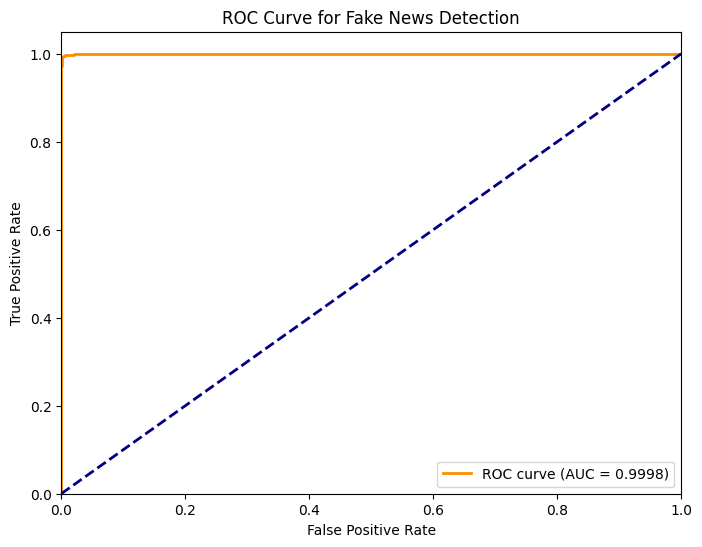

In [18]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Calculate ROC-AUC
roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1])
print(f"ROC-AUC Score: {roc_auc:.4f}")

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:, 1])
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Fake News Detection')
plt.legend(loc="lower right")
plt.show()

## Testing

In [26]:
import pandas as pd
import numpy as np
import joblib
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk

# Download required NLTK data if not already present
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

# Text preprocessing functions (same as used during training)
def preprocess_text(text):
    if pd.isna(text) or text == "":
        return ""
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Remove extra whitespace
    text = ' '.join(text.split())
    
    return text

def remove_stopwords_simple(text):
    try:
        stop_words = set(stopwords.words('english'))
        # Simple word splitting instead of complex tokenization
        words = text.split()
        filtered_text = [word for word in words if word.lower() not in stop_words and len(word) > 2]
        return ' '.join(filtered_text)
    except:
        return text  # Return original text if any error occurs

def predict_news_article(title, text, model_path='fake_news_rf_model.pkl', vectorizer_path='tfidf_vectorizer.pkl'):
    """
    Predict whether a news article is fake or true
    
    Parameters:
    title (str): Article title
    text (str): Article content
    model_path (str): Path to saved model
    vectorizer_path (str): Path to saved vectorizer
    
    Returns:
    dict: Prediction results with confidence scores
    """
    try:
        # Load the saved model and vectorizer
        print("Loading saved model and vectorizer...")
        model = joblib.load(model_path)
        vectorizer = joblib.load(vectorizer_path)
        
        # Preprocess the input
        clean_title = preprocess_text(title)
        clean_text = preprocess_text(text)
        combined_text = clean_title + ' ' + clean_text
        final_text = remove_stopwords_simple(combined_text)
        
        # Transform using the fitted vectorizer
        text_vector = vectorizer.transform([final_text])
        
        # Make prediction
        prediction = model.predict(text_vector)[0]
        probabilities = model.predict_proba(text_vector)[0]
        
        # Get confidence scores
        true_confidence = probabilities[0] * 100  # Confidence for TRUE (label 0)
        fake_confidence = probabilities[1] * 100  # Confidence for FAKE (label 1)
        
        # Determine result
        result = "FAKE" if prediction == 1 else "TRUE"
        confidence = max(probabilities) * 100
        
        return {
            'prediction': result,
            'confidence': confidence,
            'true_probability': true_confidence,
            'fake_probability': fake_confidence,
            'raw_prediction': int(prediction)
        }
        
    except FileNotFoundError as e:
        return {
            'error': f"Model files not found: {e}",
            'note': "Make sure you have trained and saved the model first"
        }
    except Exception as e:
        return {
            'error': f"An error occurred: {e}"
        }

# Test News Articles
news_articles = [
    {
        "id": 1,
        "title": "Woman sentenced in case that sparked Springfield cat-eating rumours",
        "text": """An American woman whose case was one of the sparks behind a baseless claims about Haitian immigrants has been sentenced to a year in prison for animal cruelty.
        Authorities said that Allexis Ferrell, 27, attacked a cat in Canton, Ohio.
        Ferrell is a US citizen and the incident happened about 170 miles (270km) away from a large Haitian community in Springfield, Ohio.
        Her case was one of several incidents cited online, which fed into rumours about immigrant eating pets. The stories were eventually repeated by President-elect Donald Trump and his vice-presidential running mate, Ohio Senator JD Vance.
        Ferrell was sentenced on Monday after previously pleading guilty to cruelty to companion animals.
        She also was ordered to serve an additional 18 months for violating probation conditions from a previous child endangerment charge.
        On 16 August, Canton police responded to a report of a woman smashing a cat's head with her foot and eating the animal.
        An officer saw blood on her feet and fur on her lips, according to local news reports.
        According to the Canton Repository newspaper, Stark County Common Pleas Judge Frank Forchione told Ferrell: "This is repulsive to me. I mean, that anyone would do this to an animal.
        "I can't express the disappointment, shock, disgust that this crime has brought to me," the judge said at the sentencing hearing.
        In several posts online, Ferrell was falsely described as an immigrant.
        However, Canton Police told the BBC that they had "not dealt with any complaints of Haitian immigrants at all."
        Springfield police also denied the rumours, saying at the time: "There have been no credible reports or specific claims of pets being harmed, injured or abused by individuals within the immigrant community."
        Springfield is a city of about 60,000 people in south-west Ohio, where 12,000 to 20,000 Haitian immigrants have settled in recent years, mostly drawn by work in local factories.
        Rumours about eating pets circulated in the city earlier this year, before the Canton incident. An unrelated post on Reddit appeared to show a man carrying a dead bird in Columbus, Ohio, and a Facebook message mentioning the rumours was posted on a Springfield crime board.
        These disparate stories were grafted together by anti-immigrant and pro-Trump influencers online, forging an unsubstantiated rumour later repeated by Vance online – that foreigners were catching and consuming pets in Springfield.
        During the presidential debate in September, Trump said: "In Springfield, they are eating the dogs. The people that came in, they are eating the cats."
        Vance later told CNN that the pet-eating stories were based on "first-hand account of my constituents" but did not provide further details.""",
        "expected": "TRUE"  # This appears to be a legitimate news report
    },
    {
        "id": 2,
        "title": "Pakistani Air Force Downs Indian Sukhoi Jet in POK",
        "text": """A report claiming that the Pakistani Air Force had successfully shot down an Indian Sukhoi fighter jet over Pakistan-Occupied Kashmir (POK) went viral on social media platforms. The story alleged that the pilot was captured alive and that the incident marked a significant escalation in the ongoing tensions between India and Pakistan. Accompanying the report were images purportedly showing the wreckage of the downed aircraft and the captured pilot.
www.ndtv.com

However, upon investigation, India's Press Information Bureau (PIB) and other fact-checking agencies debunked the claim, stating that no such incident had occurred. The images used were found to be old and unrelated to the current context, having been recycled from previous, unrelated events. The Indian government confirmed that all its aircraft were accounted for and that no engagements had taken place in the region as described.
The Times of India

This incident underscores the importance of verifying information through official channels before accepting and sharing news, especially in sensitive geopolitical contexts where misinformation can escalate tensions.""",
        "expected": "TRUE"  # This also appears to be legitimate news reporting
    }
]

def run_comprehensive_test():
    """Run comprehensive testing on the news articles"""
    
    print("=" * 80)
    print("FAKE NEWS DETECTION MODEL - TESTING WITH REAL EXAMPLES")
    print("=" * 80)
    
    results = []
    
    for article in news_articles:
        print(f"\n{'='*60}")
        print(f"TESTING ARTICLE {article['id']}")
        print(f"{'='*60}")
        
        print(f"\nTitle: {article['title']}")
        print(f"Expected Classification: {article['expected']}")
        print(f"\nContent Preview: {article['text'][:200]}...")
        
        # Make prediction
        prediction_result = predict_news_article(article['title'], article['text'])
        
        print(f"\n{'*'*40}")
        print("PREDICTION RESULTS:")
        print(f"{'*'*40}")
        
        if 'error' in prediction_result:
            print(f" ERROR: {prediction_result['error']}")
            if 'note' in prediction_result:
                print(f" NOTE: {prediction_result['note']}")
        else:
            print(f" PREDICTION: {prediction_result['prediction']}")
            print(f" CONFIDENCE: {prediction_result['confidence']:.2f}%")
            print(f" TRUE PROBABILITY: {prediction_result['true_probability']:.2f}%")
            print(f" FAKE PROBABILITY: {prediction_result['fake_probability']:.2f}%")
            
            # Check if prediction matches expectation
            is_correct = prediction_result['prediction'] == article['expected']
            status_emoji = "T" if is_correct else "F"
            print(f"{status_emoji} MATCHES EXPECTED: {is_correct}")
            
            # Add interpretation
            if prediction_result['confidence'] > 80:
                confidence_level = "HIGH"
            elif prediction_result['confidence'] > 60:
                confidence_level = "MEDIUM"
            else:
                confidence_level = "LOW"
            
            print(f" CONFIDENCE LEVEL: {confidence_level}")
            
        results.append({
            'article_id': article['id'],
            'title': article['title'][:50] + "...",
            'expected': article['expected'],
            'prediction': prediction_result.get('prediction', 'ERROR'),
            'confidence': prediction_result.get('confidence', 0),
            'correct': prediction_result.get('prediction') == article['expected']
        })
    
    # Summary
    print(f"\n{'='*60}")
    print("TESTING SUMMARY")
    print(f"{'='*60}")
    
    successful_predictions = [r for r in results if r['prediction'] != 'ERROR']
    correct_predictions = [r for r in successful_predictions if r['correct']]
    
    if successful_predictions:
        accuracy = len(correct_predictions) / len(successful_predictions) * 100
        avg_confidence = sum(r['confidence'] for r in successful_predictions) / len(successful_predictions)
        
        print(f" Total Articles Tested: {len(news_articles)}")
        print(f" Successful Predictions: {len(successful_predictions)}")
        print(f" Correct Predictions: {len(correct_predictions)}")
        print(f" Accuracy: {accuracy:.1f}%")
        print(f" Average Confidence: {avg_confidence:.1f}%")
        
        print(f"\n DETAILED RESULTS:")
        for result in results:
            status = " " if result['correct'] else " "
            print(f"{status} {result['title']} -> {result['prediction']} ({result['confidence']:.1f}%)")
    else:
        print(" No successful predictions - check if model files exist!")
    
    return results

# Run the test if this script is executed directly
if __name__ == "__main__":
    # Note: Make sure your model files exist before running
    print(" Starting Fake News Detection Model Test...")
    print(" Looking for model files: 'fake_news_rf_model.pkl' and 'tfidf_vectorizer.pkl'")
    
    test_results = run_comprehensive_test()


 Starting Fake News Detection Model Test...
 Looking for model files: 'fake_news_rf_model.pkl' and 'tfidf_vectorizer.pkl'
FAKE NEWS DETECTION MODEL - TESTING WITH REAL EXAMPLES

TESTING ARTICLE 1

Title: Woman sentenced in case that sparked Springfield cat-eating rumours
Expected Classification: TRUE

Content Preview: An American woman whose case was one of the sparks behind a baseless claims about Haitian immigrants has been sentenced to a year in prison for animal cruelty.
        Authorities said that Allexis Fe...
Loading saved model and vectorizer...

****************************************
PREDICTION RESULTS:
****************************************
 PREDICTION: FAKE
 CONFIDENCE: 65.27%
 TRUE PROBABILITY: 34.73%
 FAKE PROBABILITY: 65.27%
F MATCHES EXPECTED: False
 CONFIDENCE LEVEL: MEDIUM

TESTING ARTICLE 2

Title: Pakistani Air Force Downs Indian Sukhoi Jet in POK
Expected Classification: TRUE

Content Preview: A report claiming that the Pakistani Air Force had successfully sho